In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('datasets/breast-cancer-wisconsin.csv',delimiter=';',header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
data_ = data.drop(columns=[6])

In [5]:
data_.shape

(699, 10)

In [6]:
train_size = round(0.7 * data_.shape[0])

In [7]:
train_size

489

In [8]:
X_train = data_.iloc[:train_size,1:9].values
y_train = data_.iloc[:train_size,9].values
X_valid = data_.iloc[train_size:,1:9].values
y_valid = data_.iloc[train_size:,9].values

In [9]:
y_train = np.where(y_train == 2, 0, 1)
y_valid = np.where(y_valid == 2, 0, 1)

In [10]:
class NeuralNetwork(object):
    def __init__(self,l2=0.0,n_hidden=30,epochs=30,learning_rate=0.01,shuffle=True,minibatch=1,seed=None,typ='sig'):
        self.random = np.random.RandomState(seed)
        self.l2 = l2
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.minibatch = minibatch
        self.shuffle = shuffle
        self.typ = typ
        
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
        
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def gaussian(self, z):
        return np.exp(-z**2.0)
    
    def forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        if self.typ == 'sig':
            a_h = self.sigmoid(z_h)
        else:
            a_h = self.gaussian(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        if self.typ == 'sig':
            a_out = self.sigmoid(z_out)
        else:
            a_out = self.gaussian(z_out)

        return z_h, a_h, z_out, a_out
    
    def compute_cost(self, y_enc, output):
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self.forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch +
                                   1, self.minibatch):
                batch_idx = indices[start_idx:start_idx + self.minibatch]

                z_h, a_h, z_out, a_out = self.forward(X_train[batch_idx])

                sigma_out = a_out - y_train_enc[batch_idx]
                
                if self.typ == 'sig':
                    activation_derivative_h = a_h * (1. - a_h)
                else:
                    activation_derivative_h = -2.0 * a_h * np.exp(-a_h**2.0)
                    
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           activation_derivative_h)

                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                self.w_h -= self.learning_rate * delta_w_h
                self.b_h -= self.learning_rate * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.learning_rate * delta_w_out
                self.b_out -= self.learning_rate * delta_b_out
                
            z_h, a_h, z_out, a_out = self.forward(X_train)
            
            cost = self.compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

### Questão 01

In [11]:
modelSig = NeuralNetwork(epochs=20)

In [12]:
modelSig.fit(X_train,y_train,X_valid,y_valid)

20/20 | Cost: 135.20 | Train/Valid Acc.: 96.32%/98.10% 

In [13]:
cost_modelSig = modelSig.eval_['cost']

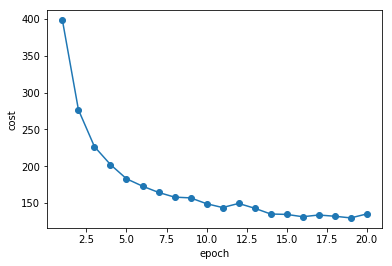

In [14]:
plt.plot(range(1,21),cost_modelSig,marker='o')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

### Questão 02

In [15]:
modelGaussian = NeuralNetwork(epochs=20,typ='gau')

In [16]:
modelGaussian.fit(X_train,y_train,X_valid,y_valid)

20/20 | Cost: 652.53 | Train/Valid Acc.: 60.33%/77.62% 

In [17]:
cost_modelGaussian = modelGaussian.eval_['cost']

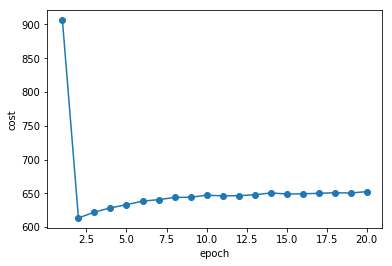

In [18]:
plt.plot(range(1,21),cost_modelGaussian,marker='o')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()